# Coexistence region around the Mott transition

In this assignment, we are going to study the coexistence region and hysteresis around the metal-insulator phase transition that is observed in DMFT. We will be using the IPT solver you wrote in the exercises.

## Some background

Let us look at a schematic $U$-$T$ phase diagram of the Hubbard model at half filling as obtained in DMFT.

<img src="figures/dmft_U_T_phase_diag.png">
(Figure taken from Georges et al., arXiv:cond-mat/0311520)

We have a first-order transition (marked in red) ending in a critical point, and various crossovers marked in blue. There is metal-insulator coexistence region around the first-order transition demarcated by the dotted lines. In this sense, there are two critical values of $U$ for the metal-insulator transition, denoted $U_{c1}$ and $U_{c2}$ in the plot above.

You can easily 'see' the coexistence region by studying the spectral function as done in the IPT tutorial. There will be a range of $U$ for which you will be able to stabilise both a metallic and insulating solution. A more convenient quantity to examine is the *quasiparticle weight* $Z$, which measures the degree of correlation of a metal. It is defined as

$$
Z = \lim_{\omega_n \rightarrow 0} \Big( 1 - \frac{d\mathrm{Im} \Sigma(i\omega_n)}{di\omega_n} \Big)^{-1}
$$

For a non-interacting metal $Z=1$. As correlations appear, $Z$ gradually gets smaller. It reaches 0 at the Mott transition.

## Your task

Your task will be to adapt your IPT DMFT code (on the Bethe lattice with $t=1.0$) to study $Z$ as a function of increasing and decreasing $U$. For low temperatures (i.e. below the critical temperature), you will see a hysteresis loop. This is suppressed at the critical point and temperatures above.

## Some hints

*Hint 1*: As you gradually increase/decrease the interaction strength $U$, remember to use $G$ from the previous $U$ value as the starting point, i.e. do not reinitialise $G$ to that corresponding to a semi-circular DOS. Otherwise, you will not be able to stabilise both phases in the coexistence region.

*Hint 2*: In order to have access to the values of $\Sigma(i\omega_n)$, you can use `sigma(n)`. This will be useful to numerically compute the derivative required to compute $Z$. You may estimate the derivative using the following approximation

$$
Z = \lim_{\omega_n \rightarrow 0} \Big( 1 - \frac{d\mathrm{Im} \Sigma(i\omega_n)}{di\omega_n} \Big)^{-1}
  \sim \Big( 1 - \frac{\mathrm{Im} \Sigma(i\omega_0)}{i\omega_0} \Big)^{-1}
$$

with $\omega_0 = \pi / \beta$ being the first Matsubara frequency.

*Hint 3*: Consider the range $U=2-5$, increasing/decreasing $U$ in steps of 0.1 for a smooth plot.

*Hint 4*: If you see spurious values of $Z$ (outside the hysteresis region), increase the number of self-consistency loops to ensure convergence.

*Hint 5*: Preferably plot $\Sigma$ with points only (no connecting lines, 'o') to see correctly the data on the Matsubara axis.

## Exercise 1

Recover the IPT impurity solver that you have created earlier.
Compute the Green function and self-energy as a function of $U$
(once increasing and once decreasing) for two different
values of the inverse temperature:

 - $\beta = 20$
 - $\beta = 0.5$
 
For both temperatures plot the quasiparticle weight $Z$ as a function of $U$ and estimate
$U_{c1}$ and $U_{c2}$. Interpret your results.

In [1]:
%matplotlib inline
import numpy as np
from triqs.gf import *
from triqs.plot.mpl_interface import plt, oplot

# change scale of all figures to make them bigger
import matplotlib as mpl
mpl.rcParams['savefig.dpi']=100 

### The solver

In [2]:
class IPTSolver:
    def __init__(self, beta):
        self.beta = beta
        self.g0_t = GfImTime(indices=[0], beta=beta)
        self.g0 = GfImFreq(indices=[0], beta=beta)
        self.sigma_t = GfImTime(indices=[0], beta=beta)
        self.sigma = GfImFreq(indices=[0], beta=beta, name='$\Sigma$')
        self.g = GfImFreq(indices=[0], beta=beta, name='$G$')

    def solve(self,U):
        # Compute second-order self-energy
        self.g0_t << Fourier(self.g0)
        self.sigma_t << U**2 * self.g0_t * self.g0_t * self.g0_t
        self.sigma << Fourier(self.sigma_t)
        # Dyson's equation
        self.g << inverse(inverse(self.g0) - self.sigma)

### Plot of $Z$ vs $U$

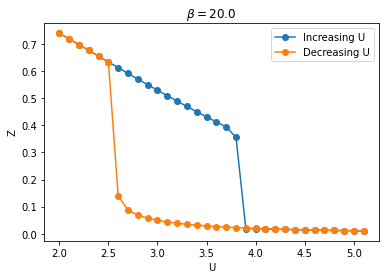

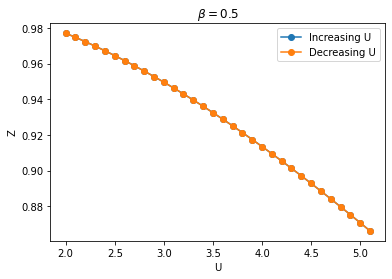

In [3]:
# Parameters of the model
t = 1.0
beta_r = [20, 0.5]
n_loops = 30
U_r = np.arange(2.0, 5.2, 0.1)

# Loop over low and high temperatures
for beta in beta_r:
    Z_list = []
    Z_list_r = []
    A = IPTSolver(beta)
    A.g << SemiCircular(2*t)
    
    # Increasing U
    for U in U_r:
        for i in range(n_loops):
            A.g0 << inverse(iOmega_n - t**2 * A.g)
            A.solve(U)        
        Z = 1 / (1 - (A.sigma(0)[0,0].imag * beta / np.pi))
        Z_list.append(Z)
        
    # Decreasing U 
    for U in U_r[::-1]:
        for i in range(n_loops):
            A.g0 << inverse(iOmega_n - t**2 * A.g)
            A.solve(U)
        Z = 1 / (1 - (A.sigma(0)[0,0].imag * beta / np.pi))
        Z_list_r.append(Z)
    
    # Plotting
    plt.figure()
    plt.title(r'$\beta = %2.1f$'%beta)
    plt.plot(U_r, Z_list, '-o', label='Increasing U')
    plt.plot(U_r[::-1], Z_list_r, '-o', label='Decreasing U')
    plt.xlabel('U')
    plt.ylabel('Z')
    plt.legend()

### Interpretation

The upper graph (low temperature, $\beta=20$) shows that the system is a
metal (i.e., poorly correlated,  $Z \sim 1$) for  $U < 2.6$, a Mott insulator for
$U > 3.9$ (i.e., strongly correlated, $Z\ll 1$), and a coexistence of metallic and
insulating phases for $2.6 < U < 3.9$. With reference to the work by Georges et al.,
one finds  $U_{c1}=2.6$ and  $U_{c2}=3.9$.

The lower graph (high temperature,  $\beta = 0.5$)
shows that the coexistence region disappears, i.e., there is no hysteresis when sweeping up
and down the interaction. Referring to the phase diagram illustrated in the introduction,
one conludes that such temperature is above  $T_c$. The Mott insulating region cannot
be reached within the range of U considered here, as suggested by the fact that the
quasiparticle weight $Z$ remains above 0.8 over the whole range of $U$.

## Exercise 2

Plot the self-energy $\Sigma(i\omega_n)$ for $U < U_c$ and $U > U_c$, e.g. $U=1$ and $U=6$. Make sure you are converged (i.e. use a large enough number of self-consistency loops). You can
do this for $\beta = 20$. Interpret your results and relate them with the results you have obtained
earlier for $Z$.

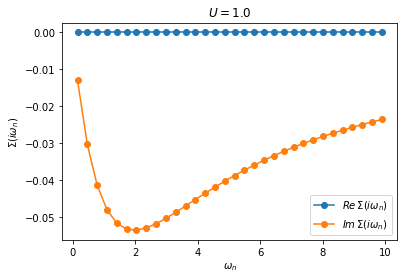

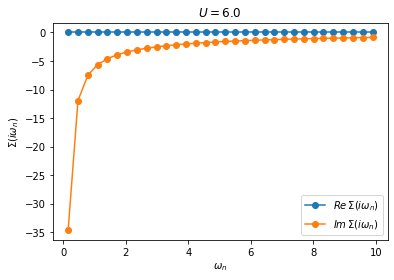

In [4]:
t=1.0
beta = 20
n_loops = 60
U_list = [1,6]
Z_list = []

A = IPTSolver(beta)
A.g << SemiCircular(2*t)
    
# Loop over values of U
for U in U_list:
    for i in range(n_loops):
        A.g0 << inverse(iOmega_n - t**2 * A.g)
        A.solve(U)
    Z = 1 / (1 - (A.sigma(0)[0,0].imag * beta / np.pi))
    Z_list.append(Z)

    plt.figure()
    plt.title('$U = %2.1f$'%U)
    oplot(A.sigma, '-o', mode='R', x_window=(0,10), label=r'$Re\, \Sigma (i\omega _n)$')
    oplot(A.sigma, '-o', mode='I', x_window=(0,10), label=r'$Im\, \Sigma (i\omega _n)$')
    plt.legend()

### Interpretation

We know that $\Sigma(i\omega_n)$ is directly related to $Z$
through

$$Z = \lim_{\omega_n \rightarrow 0}
  \Big(1 − \frac{d \mathrm{Im}\Sigma(i\omega_n)}{d i\omega_n} \Big)^{−1}$$
 
For $U=6$, for instance, we are expecting to be in the Mott insulating region of the diagram.
Indeed we find that $\frac{d \mathrm{Im}\Sigma(i\omega_n)}{d i\omega_n}$
explodes at $\omega_n = 0$. This means that $Z$ rapidly goes to zero, as expected for a
Mott insulator, which has a high degree of correlations.